<a href="https://colab.research.google.com/github/lukereichold/3D-MNIST-S4TF/blob/master/3D_MNIST_Classifier_with_S4TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⚙️ Install Dependencies

In [1]:
import TensorFlow
import Foundation

#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif
print(Python.version)

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [0]:
let h5py = Python.import("h5py")
let np = Python.import("numpy")
let os = Python.import("os")
let plt = Python.import("matplotlib.pyplot")
let cm = Python.import("matplotlib.cm")

In [3]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## ⬇ Fetch Dataset
3D Point Vectors fetched initially from https://www.kaggle.com/daavoo/3d-mnist/data (29 Mb)

In [4]:
os.system("wget https://www.dropbox.com/s/mvre9rojnjp2a36/full_dataset_vectors.h5")

--2020-03-27 19:40:55--  https://www.dropbox.com/s/mvre9rojnjp2a36/full_dataset_vectors.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mvre9rojnjp2a36/full_dataset_vectors.h5 [following]
--2020-03-27 19:40:56--  https://www.dropbox.com/s/raw/mvre9rojnjp2a36/full_dataset_vectors.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c21340e97f56af25c34e47592.dl.dropboxusercontent.com/cd/0/inline/A0slMNm65JRjGTBN0j5isS6CqZRUUTttHAOzsBf5cxrM1x22EX79WWbJ68PT1G29w6DgEUejbPgOKywNv5pB32xvlIqYm-9t4EJZjglFkfJoJxdmlpoBVENZxuuYOlfKF8w/file# [following]
--2020-03-27 19:40:56--  https://uc7c21340e97f56af25c34e47592.dl.dropboxusercontent.com/cd/0/inline/A0slMNm65JRjGTBN0j5isS6CqZRUUTttHAOzsBf5cxrM1x22EX79WWbJ68PT1G29w6DgEUejbPgOKy

0


In [5]:
let dataset = h5py.File("full_dataset_vectors.h5", "r")

func floatTensor(from data: PythonObject) -> Tensor<Float> {
  return Tensor<Float>(numpy: data.value.astype(np.float32))!
}

func intTensor(from data: PythonObject) -> Tensor<Int32> {
  return Tensor<Int32>(numpy: data.value.astype(np.int32))!
}

var trainingFeatures = floatTensor(from: dataset["X_train"])
var trainingLabels = intTensor(from: dataset["y_train"])

var testFeatures = floatTensor(from: dataset["X_test"])
var testLabels = intTensor(from: dataset["y_test"])

sys:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


## 📐 Verify Initial Dataset Shapes

In [0]:
assert(trainingFeatures.shape == TensorShape([10_000, 4096]))
assert(trainingLabels.shape == TensorShape([10_000]))

assert(testFeatures.shape == TensorShape([2_000, 4096]))
assert(testLabels.shape == TensorShape([2_000]))

let trainingSize = trainingFeatures.shape[0]
let testSize = testFeatures.shape[0]

## 🌈 Give Each Point a Color

Each sample represents an "MNIST digit" in three-dimensional space (x, y, z coordinates), where each  of the 4096 possible points has a color. 

In [0]:
var coloredTrainingSamples = Tensor<Float>(ones: TensorShape([10_000, 4096, 3]))
var coloredTestSamples = Tensor<Float>(ones: TensorShape([2_000, 4096, 3]))

let trainingNp = trainingFeatures.makeNumpyArray()
let testNp = testFeatures.makeNumpyArray()
let scalarMap = cm.ScalarMappable(cmap: "Oranges")

func addColorDimension(scalars: PythonObject) -> Tensor<Float> {
  let rgba = scalarMap.to_rgba(scalars).astype(np.float32)
  let colorValues = Tensor<Float>(numpy: rgba)!
  return colorValues[TensorRange.ellipsis, ..<3]
}

for i in 0 ..< trainingSize {
  coloredTrainingSamples[i] = addColorDimension(scalars: trainingNp[i])
}

for i in 0 ..< testSize {
  coloredTestSamples[i] = addColorDimension(scalars: testNp[i])
}

## 🔲 Expand Points to Three Dimensions

Reshape each sample to be represented as a rank-4 tensor of shape `(16, 16, 16, 3)`.

In [8]:
coloredTrainingSamples = coloredTrainingSamples.reshaped(to: TensorShape(trainingSize, 16, 16, 16, 3))
coloredTestSamples = coloredTestSamples.reshaped(to: TensorShape(testSize, 16, 16, 16, 3))

let coloredTrainingSamplesNp = coloredTrainingSamples.makeNumpyArray()
let trainingLabelsNp = trainingLabels.makeNumpyArray()

print(coloredTrainingSamples.shape)
print(coloredTestSamples.shape)

[10000, 16, 16, 16, 3]
[2000, 16, 16, 16, 3]


## 📚 Defining Our Network

In [0]:
let frame_height = 16, frame_width = 16, frame_depth = 16
let RGB_channels = 3
let classCount = 10

let input_shape = (frame_depth, frame_height, frame_width, RGB_channels)

struct Classifier: Layer {
    
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>
    
    var conv1 = Conv3D<Float>(filterShape: (3, 3, 3, RGB_channels, 8), padding: .same, activation: relu)
    var conv2 = Conv3D<Float>(filterShape: (3, 3, 3, 8, 16), padding: .same, activation: relu)
    var pool = MaxPool3D<Float>(poolSize: (2, 2, 2), strides: (2, 2, 2))

    var conv3 = Conv3D<Float>(filterShape: (3, 3, 3, 16, 32), padding: .same, activation: relu)
    var conv4 = Conv3D<Float>(filterShape: (3, 3, 3, 32, 64), padding: .same, activation: relu)

    var batchNorm = BatchNorm<Float>(featureCount: 64)
    var flatten = Flatten<Float>()
    
    var dense1 = Dense<Float>(inputSize: 4096, outputSize: 4096, activation: relu)
    var dense2 = Dense<Float>(inputSize: 4096, outputSize: 1024, activation: relu)

    var dropout25 = Dropout<Float>(probability: 0.25)
    var dropout50 = Dropout<Float>(probability: 0.5)
  
    var output = Dense<Float>(inputSize: 1024, outputSize: classCount, activation: softmax)

    @differentiable
    func callAsFunction(_ input: Input) -> Output {
      return input
      .sequenced(through: conv1, conv2, pool)
      .sequenced(through: conv3, conv4, batchNorm, pool)
      .sequenced(through: dropout25, flatten, dense1, dropout50)
      .sequenced(through: dense2, dropout50, output)
    }
}

In [0]:
var model = Classifier()

In [11]:
let dummy = Tensor<Float>(randomNormal: TensorShape(1, 16, 16, 16, 3))
let eval = model(dummy)

assert(eval.shape == TensorShape([1, 10]))
print(eval.shape)

[1, 10]


## 📈 Training

In [0]:
let batchSize = 100
let epochs = 50

In [0]:
let optimizer = Adam(for: model, learningRate: 1e-5, decay: 1e-6)

In [0]:
var trainAccHistory = np.zeros(epochs)
var valAccHistory = np.zeros(epochs)

var trainLossHistory = np.zeros(epochs)
var valLossHistory = np.zeros(epochs)

In [15]:
for epoch in 0 ..< epochs {

    Context.local.learningPhase = .training

    // Shuffle samples
    let shuffledIndices = np.random.permutation(trainingSize)
    let shuffledSamples = coloredTrainingSamplesNp[shuffledIndices]
    let shuffledLabels = trainingLabelsNp[shuffledIndices]

    // Loop over each batch of samples
    for batchStart in stride(from: 0, to: trainingSize, by: batchSize) {
      let batchRange = batchStart ..< batchStart + batchSize
      let labels = Tensor<Int32>(numpy: shuffledLabels[batchRange])!
      let samples = Tensor<Float>(numpy: shuffledSamples[batchRange])!

      let (_, gradients) = valueWithGradient(at: model) { model -> Tensor<Float> in
          let logits = model(samples)
          return softmaxCrossEntropy(logits: logits, labels: labels)
      }
      optimizer.update(&model, along: gradients)
    }

    // Evaluate model
    Context.local.learningPhase = .inference

    var correctTrainGuessCount = 0
    var totalTrainGuessCount = 0

    for batchStart in stride(from: 0, to: trainingSize, by: batchSize) {
      let batchRange = batchStart ..< batchStart + batchSize
      let labels = Tensor<Int32>(numpy: shuffledLabels[batchRange])!
      let samples = Tensor<Float>(numpy: shuffledSamples[batchRange])!

      let logits = model(samples)

      // accuracy
      let correctPredictions = logits.argmax(squeezingAxis: 1) .== labels
      correctTrainGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())

      // loss
      trainLossHistory[epoch] += PythonObject(softmaxCrossEntropy(logits: logits, labels: labels).scalarized())
    }

    let trainAcc = Float(correctTrainGuessCount) / Float(trainingSize)
    trainAccHistory[epoch] = PythonObject(trainAcc)

    var correctValGuessCount = 0
    var totalValGuessCount = 0

    for batchStart in stride(from: 0, to: testSize, by: batchSize) {
        let batchRange = batchStart ..< batchStart + batchSize
        let labels = testLabels[batchRange]
        let samples = coloredTestSamples[batchRange]

        let logits = model(samples)

        // accuracy
        let correctPredictions = logits.argmax(squeezingAxis: 1) .== labels
        correctValGuessCount += Int(Tensor<Int32>(correctPredictions).sum().scalarized())

        // loss
        valLossHistory[epoch] += PythonObject(softmaxCrossEntropy(logits: logits, labels: labels).scalarized())
    }

    let valAcc = Float(correctValGuessCount) / Float(testSize)
    valAccHistory[epoch] = PythonObject(valAcc)
    
    print("\(epoch + 1) | Training accuracy: \(trainAcc) | Validation accuracy: \(valAcc)")
}

1 | Training accuracy: 0.1573 | Validation accuracy: 0.161
2 | Training accuracy: 0.2549 | Validation accuracy: 0.265
3 | Training accuracy: 0.3134 | Validation accuracy: 0.317
4 | Training accuracy: 0.3721 | Validation accuracy: 0.369
5 | Training accuracy: 0.4083 | Validation accuracy: 0.398
6 | Training accuracy: 0.4471 | Validation accuracy: 0.4485
7 | Training accuracy: 0.4813 | Validation accuracy: 0.4725
8 | Training accuracy: 0.4936 | Validation accuracy: 0.49
9 | Training accuracy: 0.5097 | Validation accuracy: 0.504
10 | Training accuracy: 0.5237 | Validation accuracy: 0.518
11 | Training accuracy: 0.5399 | Validation accuracy: 0.5285
12 | Training accuracy: 0.5605 | Validation accuracy: 0.551
13 | Training accuracy: 0.575 | Validation accuracy: 0.5615
14 | Training accuracy: 0.5822 | Validation accuracy: 0.568
15 | Training accuracy: 0.5856 | Validation accuracy: 0.571
16 | Training accuracy: 0.5918 | Validation accuracy: 0.5765
17 | Training accuracy: 0.6033 | Validation ac

## 🕝 Inspecting training history

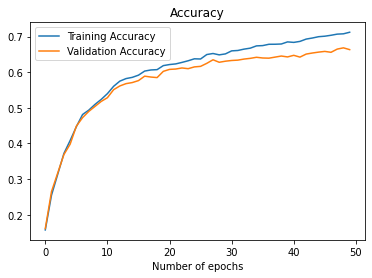

None


In [16]:
plt.plot(trainAccHistory, label: "Training Accuracy")
plt.plot(valAccHistory, label: "Validation Accuracy")
plt.xlabel("Number of epochs")
plt.legend()
plt.title("Accuracy")
plt.show()

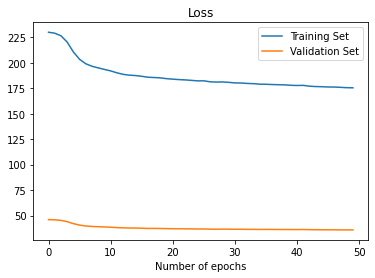

None


In [17]:
plt.plot(trainLossHistory, label: "Training Set")
plt.plot(valLossHistory, label: "Validation Set")
plt.xlabel("Number of epochs")
plt.legend()
plt.title("Loss")
plt.show()

## 🌐 Making Inferences

With our model now trained, we can make inferences to predict the class labels of samples outside the training set.

In [18]:
let randomIndex = Int.random(in: 0 ..< testSize)
var randomSample = coloredTestSamples[randomIndex].reshaped(to: TensorShape(1, 16, 16, 16, 3))

let label = testLabels[randomIndex]

print("Predicted: \(model(randomSample).argmax()), Actual: \(label)")

Predicted: 3, Actual: 3
